# Day 13: Monte Carlo

---

- Reminder on probability stuff



In [1]:
import pandas as pd 
import grama as gr 
import numpy as np
from scipy.optimize import minimize
from plotnine import *
DF = gr.Intention()

## Dataset of steel alloy specimens
from grama.data import df_ruff


## Reminder

---


/home/zach/.local/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


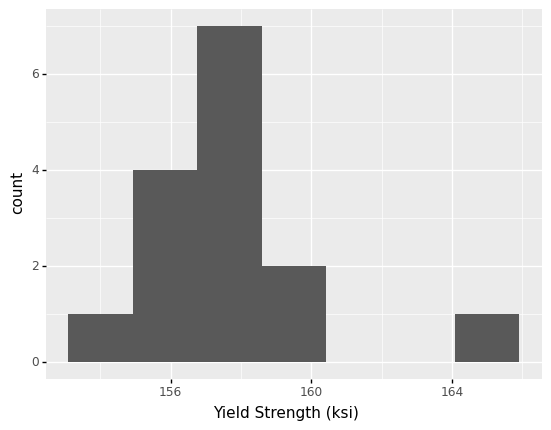

<ggplot: (8767586609324)>

In [19]:
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_histogram()
    + labs(x="Yield Strength (ksi)")
)

Fit a distribution to model the random quantity

In [3]:
## Fit a marginal
marg_tys = gr.marg_named(df_ruff.TYS, "lognorm")

We can use a distribution to compute useful quantities, for example a critical value associated with a desired failure rate (using the quantile function):


TYS lower ~ 154.698


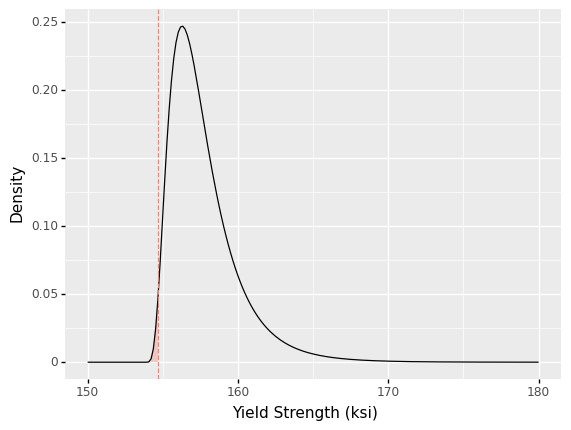

<ggplot: (8767586691572)>

In [4]:
## Compute lower quantile as design value
tys_lower = marg_tys.q(0.01)
print("TYS lower ~ {0:4.3f}".format(tys_lower))

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(DF.TYS <= tys_lower),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    + geom_vline(
        xintercept=tys_lower,
        linetype="dashed",
        color="salmon",
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)

### The Mean of a Random Variable

We denote the mean ([expectation](https://en.wikipedia.org/wiki/Expected_value)) of a random variable by $\mathbb{E}[X] = \mu_X$. The mean is often used as a metric of "central tendency".


In [5]:
(
    df_ruff
    >> gr.tf_summarize(
        TYS_mean=gr.mean(DF.TYS),
        TUS_mean=gr.mean(DF.TUS),
    )
)

,TYS_mean,TUS_mean
0,157.733333,165.24


The mean is useful as a typical value


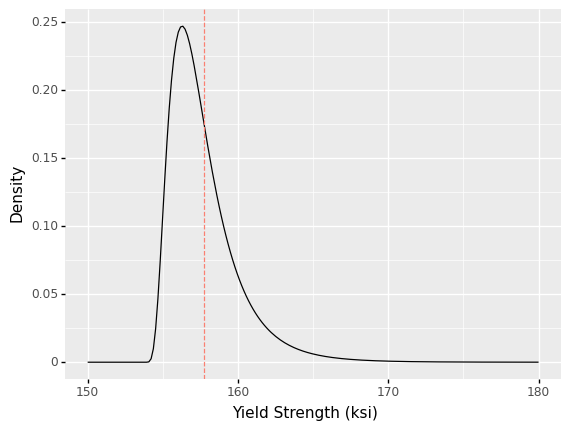

<ggplot: (8767586670183)>

In [6]:
## Estimate TYS mean
tys_mean = (
    df_ruff
    >> gr.tf_summarize(tys_mean=gr.mean(DF.TYS))
).tys_mean[0]

## Evaluate marginal at many points
df_density = gr.df_make(TYS=np.linspace(150, 180, num=200))
df_density["l"] = list(map(marg_tys.l, df_density.TYS))

## Visualize
(
    df_ruff
    >> ggplot(aes("TYS"))
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    + geom_vline(
        xintercept=tys_mean,
        linetype="dashed",
        color="salmon",
    )
    
    + labs(
        y="Density",
        x="Yield Strength (ksi)"
    )
)


The mean $\mu$ is also important as it is core to how we do stochastic simulation. We'll see more as we talk about Monte Carlo below.


## Motivation: Random Variable Interactions

---

Let $Z$ be normally distributed; we write $Z \sim N(\mu, \sigma^2)$.

We can use a marginal to plot the distribution, compute probabilities, etc.


norm lower ~ -2.326


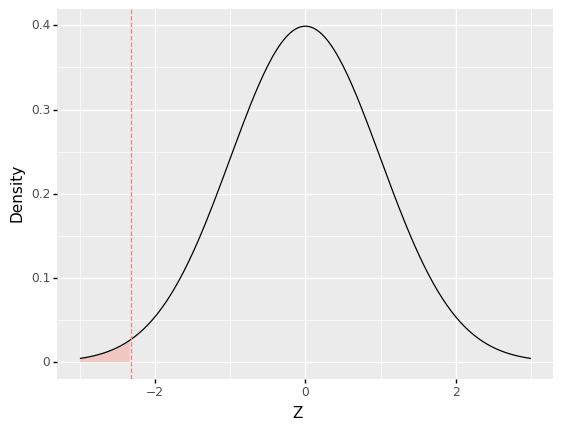

<ggplot: (8767586697198)>

In [7]:
## Compute lower quantile as design value
marg_norm = gr.MarginalNamed(d_name="norm", d_param=dict(loc=0, scale=1))
norm_lower = marg_norm.q(0.01)
print("norm lower ~ {0:4.3f}".format(norm_lower))

## Evaluate marginal at many points
df_density = gr.df_make(norm=np.linspace(-3, +3, num=200))
df_density["l"] = list(map(marg_norm.l, df_density.norm))

## Visualize
(
    df_ruff
    >> ggplot(aes("norm"))
    + geom_ribbon(
        data=df_density
        >> gr.tf_filter(DF.norm <= norm_lower),
        mapping=aes(ymax="l", ymin=0),
        fill="salmon",
        alpha=1/3,
    )
    + geom_line(
        data=df_density,
        mapping=aes(y="l")
    )
    + geom_vline(
        xintercept=norm_lower,
        linetype="dashed",
        color="salmon",
    )
    
    + labs(
        y="Density",
        x="Z"
    )
)

But what if we consider $X = Z^2$? Can this be a normal distribution?

$$X = Z^2$$

<br><br><br>

(Some vertical space to build anticipation....)

<br><br><br>

eval_monte_carlo() is rounding n...


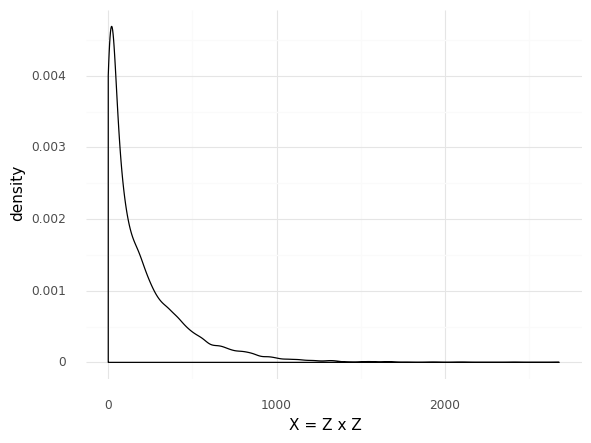

<ggplot: (8767584797739)>

In [24]:
(
    ## Build a simple model
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(X=df.Z**2),
        var=["Z"],
        out=["X"],
    )
    >> gr.cp_marginals(Z=dict(dist="norm", loc=10, scale=10))
    >> gr.cp_copula_independence()
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    ## Visualize
    >> ggplot(aes("X"))
#     + coord_cartesian(xlim=(0, 1.2e6))
    + geom_density()
    + theme_minimal()
    + labs(x="X = Z x Z")
)

It's not possible for $Z^2 < 0$! The two values in $Z^2 = Z \times Z$ must always have the same sign. So the result $Z^2$ can't *possibly* be a normal distribution (it can't take negative values).

*Aside*: Distributions of this form fall under the family of [chi-square distributions](https://en.wikipedia.org/wiki/Chi-square_distribution).

But what if we allow $Z_1, Z_2 \sim N(0, 1^2)$ to be *independent* normal random variables?

$$Y = Z_1 \times Z_2$$

<br><br><br>

(Some vertical space to build anticipation....)

<br><br><br>

eval_monte_carlo() is rounding n...


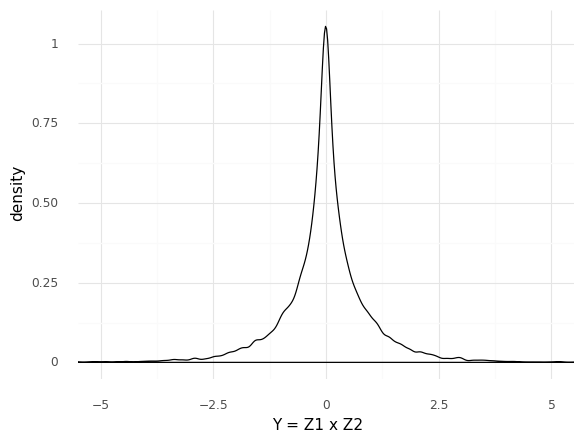

<ggplot: (8767586608044)>

In [9]:
(
    ## Build a simple model
    gr.Model()
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(Y=df.Z1 * df.Z2),
        var=["Z1", "Z2"],
        out=["Y"],
    )
    >> gr.cp_marginals(
        Z1=dict(dist="norm", loc=0, scale=1),
        Z2=dict(dist="norm", loc=0, scale=1),
    )
    >> gr.cp_copula_independence()
    ## Approximate distribution using Monte Carlo
    >> gr.ev_monte_carlo(n=1e4, df_det="nom")
    ## Visualize
    >> ggplot(aes("Y"))
    + coord_cartesian(xlim=(-5, +5))
    + geom_density()
    + theme_minimal()
    + labs(x="Y = Z1 x Z2")
)

This looks *a bit* like a normal distribution, but [it's not](https://math.stackexchange.com/questions/101062/is-the-product-of-two-gaussian-random-variables-also-a-gaussian) (it turns out to be a difference of chi-squares). We could do some sneaky math to write down a distribution for this quantity $Z_1 \times Z_2$, or we could just simulate its behavior using *Monte Carlo*.

Sometimes, modelers will pick random variables because it makes the math easy (coughnormaldistributionscough). We're going to learn Monte Carlo so we can choose random variables that best represent the underlying uncertainty, but still make quantiative statements through simulation.


## Uncertainty Propagation - Monte Carlo

---

Here's an analogy:

> - **Finite Element Analysis** (FEA) is to structural analysis, as
> - **SPICE**, and other circuit simulators, are to circuit analysis, as
> - **Monte Carlo** is to probabilistic analysis

Monte Carlo is a simulation technique.


Monte Carlo has its theoretical justification in the [law of large numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers). Let $X_i \sim \rho$ be independent and identically distributed with finite variance. Then

$$\overline{X}_n = \frac{1}{n} \sum_{i=1}^n X_i \to \mu$$

where $\mu$ is the mean of $X$

$$\mu = \int x \rho(x) dx \equiv \mathbb{E}[X].$$

Some nomenclature:

> - Each individual $X_i$ is called a *realization* of the random variable $X$. 
> - A collection of $\{X_1, \dots, X_n\}$ is called a *sample*.


As an example, let's let $Z \sim N(0, 1^2)$ (standard normal has mean $0$ and variance $\sigma^1 = 1$). This has a mean of $\mu = 0$. The following code uses Monte Carlo to approximate the mean using $\overline{X}_n$.


In [29]:
# TEMPLATE: Monte Carlo example
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(
        Z=dict(dist="norm", loc=0, scale=1) # scipy distributions "use" (mean = loc, sd = scale)
    )
    >> gr.cp_copula_independence()
    
    ## Monte Carlo: The two main steps:
#######################################
    # Draw independent, identically distributed realizations
    >> gr.ev_monte_carlo(n=100, df_det="nom", skip=True)
    # Estimate the mean
    >> gr.tf_summarize(mu_hat=gr.mean(DF.Z))
#######################################
)

Design runtime estimates unavailable; model has no timing data.


,mu_hat
0,-0.006107


Monte Carlo (usually) comes in two steps:

1. Draw **independent** realizations from our random variable(s)
  - this is what `gr.ev_monte_carlo()` does
2. Use the sample of realizations to estimate the mean
  - this is what `gr.tf_summarize()` with `gr.mean()` does


Increasing the number of realizations $n$ will tend to converge the estimate. Let's look at an example of the running average to get a sense of convergence:


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


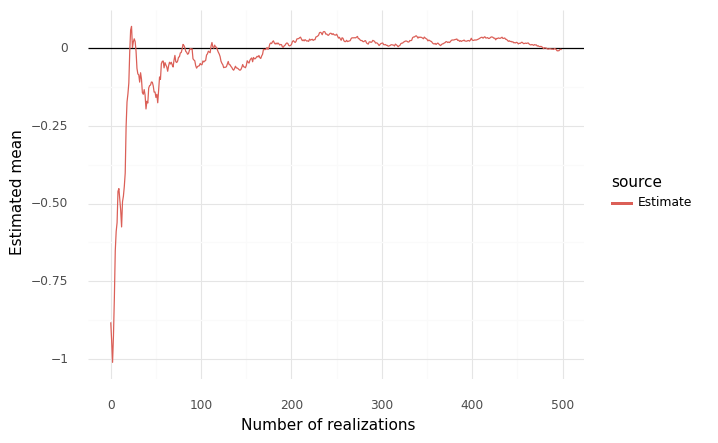

<ggplot: (8767584789267)>

In [30]:
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    ## Monte Carlo
    # Draw samples
    >> gr.ev_monte_carlo(n=5e2, df_det="nom", skip=True)
    # Compute summary
    >> gr.tf_mutate(
        # Compute the running mean, to visualize
        mu_hat=gr.cummean(DF.X),
        idx=DF.index,
    )
    
    ## Visualize
    >> gr.tf_mutate(source="Estimate")
    >> ggplot()
    + geom_hline(
        color="black",
        yintercept=0,
    )
    + geom_line(
        mapping=aes("idx", "mu_hat", color="source"),
    )
    + theme_minimal()
    + labs(
        x="Number of realizations",
        y="Estimated mean"
    )
)

Observations:

- Convergence is *not monotone*. With Monte Carlo we will *tend* to converge with more realizations $n$, but only in a long-run sense. Fluctuations will occur along the way.


## Quantifying Uncertainty

---

Note that 

$$\overline{X}_n = \frac{1}{n} \sum_{i=1}^n X_i$$

is a sum of random variables. While the quantity we're trying to estimate $\mu$ is a deterministic constant, the quantity $\overline{X}_n$ is itself a random variable. That means it is *inherently uncertain*. 

One way to represent uncertainty in an estimate is to construct a *confidence interval*.


Design runtime estimates unavailable; model has no timing data.


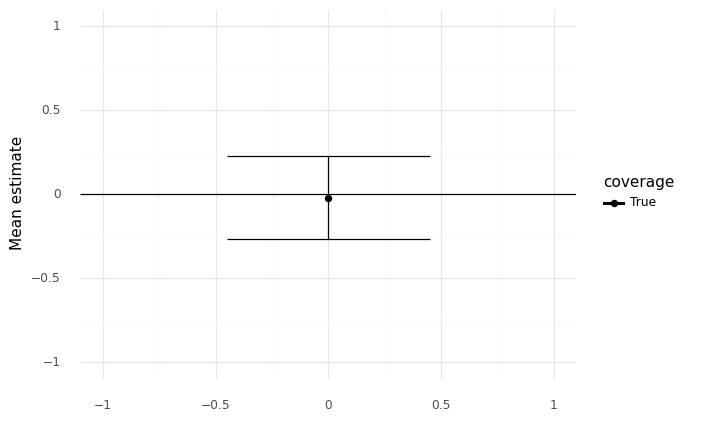

<ggplot: (8767584778668)>

In [31]:
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    ## Monte Carlo
    # Draw independent, identically distributed realizations
    >> gr.ev_monte_carlo(
        n=50, 
        df_det="nom", 
        skip=True,
    )
    # Estimate the mean
    >> gr.tf_summarize(
        mu_hat=gr.mean(DF.X),
        se_hat=gr.sd(DF.X) / gr.sqrt(gr.n(DF.index)),
    )
    >> gr.tf_mutate(
        # 1.96 corresponds to a normal-approximated 95% CI
        mu_lo=DF.mu_hat - 1.96 * DF.se_hat,
        mu_hi=DF.mu_hat + 1.96 * DF.se_hat,
    )
    >> gr.tf_mutate(
        # Does each interval contain the true value?
        coverage=(DF.mu_lo <= 0) & (0 <= DF.mu_hi)
    )
    
    ## Visualize
    >> ggplot(aes(x=0))
    + geom_hline(yintercept=0)
    + geom_errorbar(aes(ymin="mu_lo", ymax="mu_hi", color="coverage"), width=0)
    + geom_point(aes(y="mu_hat", color="coverage"), size=2)
    
    + scale_color_manual({True: "black", False: "salmon"})
    + coord_cartesian(xlim=(-1, +1), ylim=(-1, +1))
    + theme_minimal()
    + labs(x="", y="Mean estimate")
)

A confidence interval is constructed to contain the true value $\mu$ at some user-specified rate (above, 95%). However


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


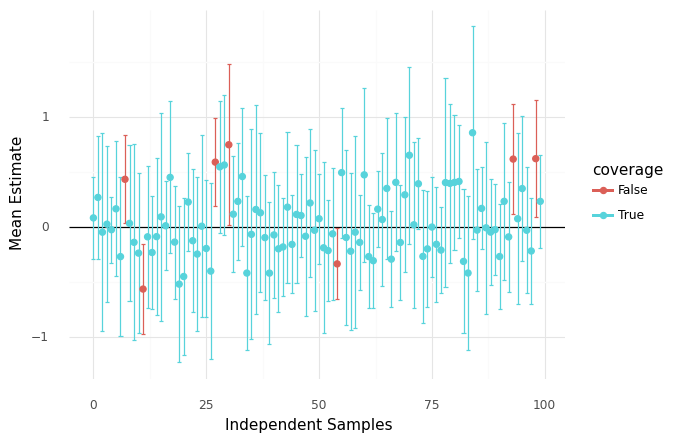

<ggplot: (8767586647429)>

In [13]:
(
    ## Set up model with a random variable
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    
    ## Monte Carlo
    # Draw independent, identically distributed realizations
    >> gr.ev_monte_carlo(n=1e3, df_det="nom", skip=True)
    # Group to create independent samples
    >> gr.tf_mutate(group=gr.floor(DF.index / 10))
    >> gr.tf_group_by(DF.group)
    # Estimate the mean
    >> gr.tf_summarize(
        mu_hat=gr.mean(DF.X),
        se_hat=gr.sd(DF.X) / gr.sqrt(gr.n(DF.index)),
    )
    >> gr.tf_mutate(
        # 1.96 corresponds to a normal-approximated 95% CI
        mu_lo=DF.mu_hat - 1.96 * DF.se_hat,
        mu_hi=DF.mu_hat + 1.96 * DF.se_hat,
    )
    >> gr.tf_mutate(
        # Does each interval contain the true value?
        coverage=(DF.mu_lo <= 0) & (0 <= DF.mu_hi)
    )
    
    ## Visualize
    >> ggplot(aes(x="group"))
    + geom_hline(yintercept=0)
    + geom_errorbar(aes(ymin="mu_lo", ymax="mu_hi", color="coverage"), width=0)
    + geom_point(aes(y="mu_hat", color="coverage"), size=2)
    
    + theme_minimal()
    + labs(x="Independent Samples", y="Mean Estimate")
)

A confidence interval will tend to *narrow* as $n$ grows larger


eval_monte_carlo() is rounding n...
Design runtime estimates unavailable; model has no timing data.


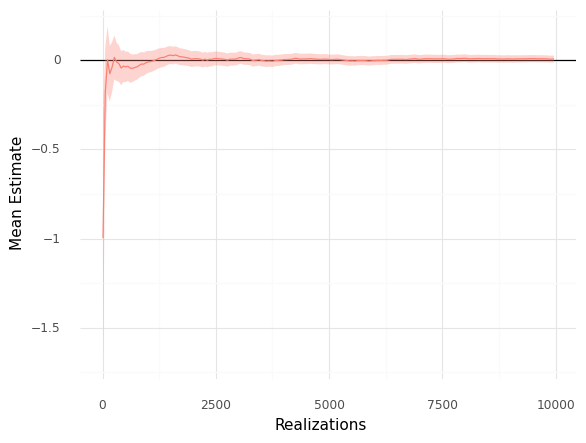

<ggplot: (8767586607963)>

In [14]:
df_sample = (
    gr.Model()
    >> gr.cp_marginals(X=dict(dist="norm", loc=0, scale=1))
    >> gr.cp_copula_independence()
    >> gr.ev_monte_carlo(n=1e4, df_det="nom", skip=True)
)

## Compute running confidence intervals
df_running = pd.DataFrame()
for i in range(10, df_sample.shape[0], 50):
    df_tmp = (
        df_sample
        >> gr.tf_head(i)
        >> gr.tf_summarize(
            mu_hat=gr.mean(DF.X),
            se_hat=gr.sd(DF.X) / gr.sqrt(gr.n(DF.index)),
        )
        >> gr.tf_mutate(
            # 1.96 corresponds to a normal-approximated 95% CI
            mu_lo=DF.mu_hat - 1.96 * DF.se_hat,
            mu_hi=DF.mu_hat + 1.96 * DF.se_hat,
            idx=i,
        )
    )
    
    df_running = pd.concat((df_running, df_tmp), axis=0)
df_running.reset_index(drop=True, inplace=True)

## Visualize
(
    df_running
    >> ggplot(aes("idx"))
    + geom_hline(yintercept=0)
    + geom_ribbon(aes(ymin="mu_lo", ymax="mu_hi"), alpha=1/3, fill="salmon")
    + geom_line(aes(y="mu_hat"), color="salmon")
    
    + theme_minimal()
    + labs(x="Realizations", y="Mean Estimate")
)

A confidence interval will tend shrink as $1 / \sqrt{n}$, so this convergence is considered *slow*. It is common to need a number of realizations on the order of $n = 1000$ for "reasonable" results.


## How do we use any of this stuff?

---

### Comparing designs

Between the following two designs, which is higher-performing?


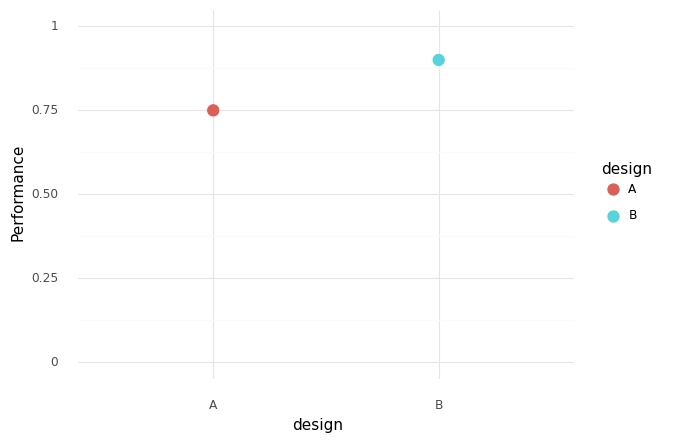

<ggplot: (8767586601870)>

In [15]:
(
    gr.df_make(
        design=["A", "B"],
        mu_lo=[0.7, 0.8],
        mu_hat=[0.75, 0.9],
        mu_hi=[0.85, 1.0],
    )
    
    >> ggplot(aes("design", color="design"))
#     + geom_errorbar(aes(ymin="mu_lo", ymax="mu_hi"))
    + geom_point(aes(y="mu_hat"), size=4)
    
    + theme_minimal()
    + coord_cartesian(ylim=(0, 1))
    + labs(y="Performance")
)

Now, between the two designs, which is higher-performing? (Assume the two intervals are confidence intervals.)


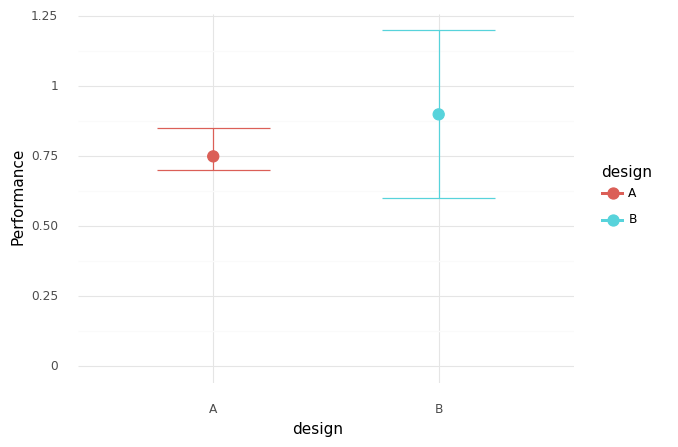

<ggplot: (8767587263266)>

In [16]:
(
    gr.df_make(
        design=["A", "B"],
        mu_lo=[0.7, 0.6],
        mu_hat=[0.75, 0.9],
        mu_hi=[0.85, 1.2],
    )
    
    >> ggplot(aes("design", color="design"))
    + geom_errorbar(aes(ymin="mu_lo", ymax="mu_hi"))
    + geom_point(aes(y="mu_hat"), size=4)
    
    + theme_minimal()
    + coord_cartesian(ylim=(0, 1.2))
    + labs(y="Performance")
)

In this case, the confidence intervals indicate that the two designs are *statistically indistinguishable*.

What possible actions could we take?

- ???


### Assessing margins




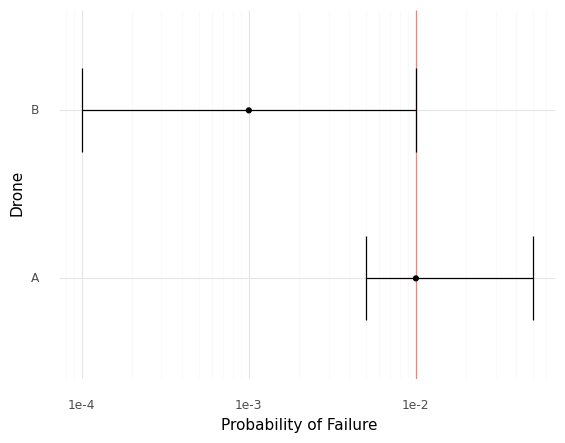

<ggplot: (8767585009282)>

In [17]:
(
    gr.df_make(
        aircraft=["A", "B"],
        p_min=[0.005, 1e-4],
        p_hat=[0.01, 1e-3],
        p_max=[0.05, 1e-2],
    )
    >> ggplot(aes(y="aircraft"))
    + geom_vline(xintercept=0.01, color="salmon")
    + geom_errorbarh(aes(xmin="p_min", xmax="p_max"))
    + geom_point(aes(x="p_hat"))
    
    + scale_x_log10()
    + theme_minimal()
    + labs(x="Probability of Failure", y="Drone")
)

Observations:

- 

(Unused: Hanford-inspired case)

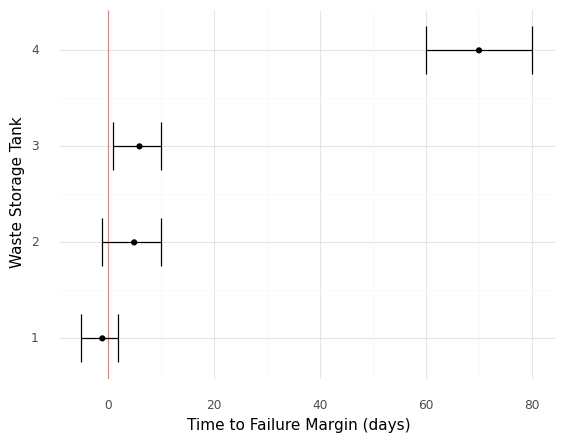

<ggplot: (8767584955173)>

In [18]:
(
    gr.df_make(
        tank=[1, 2, 3, 4],
        m_min=[-5,  -1,  +1, +60],
        m_hat=[-1,  +5,  +6, +70],
        m_max=[+2, +10, +10, +80],
    )
    >> ggplot(aes(y="tank"))
    + geom_vline(xintercept=0, color="salmon")
    + geom_errorbarh(aes(xmin="m_min", xmax="m_max"))
    + geom_point(aes(x="m_hat"))
    
    + theme_minimal()
    + labs(x="Time to Failure Margin (days)", y="Waste Storage Tank")
)